# A

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 2,index_col=0)[:1134]
data.index = pd.to_datetime(data.index,format = '%Y%m')

for column in data.columns:
    data[column] = pd.to_numeric(data[column])

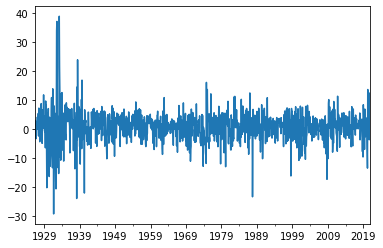

In [2]:
data['Mkt-RF'].plot()

(array([  3.,   7.,  33., 248., 666., 159.,  13.,   2.,   0.,   3.]),
 array([-29.13 , -22.332, -15.534,  -8.736,  -1.938,   4.86 ,  11.658,
         18.456,  25.254,  32.052,  38.85 ]),
 <a list of 10 Patch objects>)

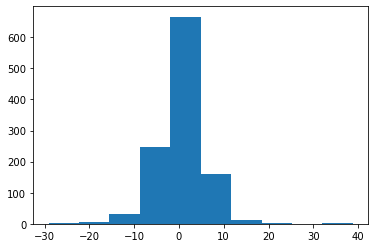

In [3]:
plt.hist(data['Mkt-RF'])

# B

The hyperparameters that I choose are mean return and standard deviation from sample during 07/1926 to 12/2013

In [4]:
σ = 5.4
m0 = data['Mkt-RF'][data.index < pd.to_datetime(201401,format = '%Y%m')].mean()
v0 = data['Mkt-RF'][data.index < pd.to_datetime(201401,format = '%Y%m')].std()

r = data['Mkt-RF'][data.index == pd.to_datetime(201312,format = '%Y%m')]
m1 = (m0*(σ**2) + r*(v0**2))/(σ**2+v0**2)
v1 = np.sqrt((v0*σ)**2/(σ**2 + v0**2))

print('m0 = %.4f' %m0)
print('v0 = %.4f' %v0)

print('one-month ahead posterior mu is %.4f' %m1)

m0 = 0.6506
v0 = 5.4290
one-month ahead posterior mu is 1.7361


# C

prior: $\mu \sim N(m_0,v_0)$, $p(\mu) = \frac{1}{\sqrt{2 \pi v_0^2}} exp(-\frac{(\mu - m_0)^2}{2v_0^2})$

likelihood: $p(r|\mu) = p(r_1|\mu)p(r_2|\mu)...p(r_T|\mu) = (\frac{1}{\sqrt{2 \pi v_0^2}})^T exp(-\sum_{t = 1}^T \frac{(r_t - \mu)^2}{2\sigma^2})$

posterior $p(\mu|r) \propto p(\mu) p(r|\mu) \propto exp(-\frac{(\mu - m_0)^2}{2v_0^2}-\sum_{t = 1}^T \frac{(r_t - \mu)^2}{2\sigma^2}) \propto exp(-\frac{(\mu - m_T)^2}{2v_T^2})$ 

that is to say, $p(\mu|r) \sim N(m_T, v_T)$

where $ m_T = \frac{m_0\sigma^2 + \bar{r}Tv_0^2}{\sigma^2 + T v_0^2}$,  $v_T = \frac{v_0^2\sigma^2}{\sigma^2 + T v_0^2}$

$p(r_{t+1}|r) = \int_{\mu}p(r_{t+1}|\mu) p(\mu|r) d\mu = \int_{\mu} \frac{1}{2 \pi \sigma v_{t}} \exp \left(-\frac{(r-\mu)^{2}}{2 \sigma^{2}}\right) \exp \left(-\frac{\left(\mu-m_{t}\right)^{2}}{2 v_{t}^{2}}\right) \mathrm{d} \mu \propto =\exp \left(-\frac{r^{2}-2 m_{t} r}{2\left(v_{t}^{2}+\sigma^{2}\right)}\right)$ 

Thus, $r_{t+1}|r_t \sim N\left(\bar{\mu}_{r, t}, \bar{\sigma}_{r, t}^{2}\right)$, where $\bar{\mu}_{r, t}=m_T, \bar{\sigma}_{r, t}^{2}=\sigma^{2}+v_{t}^{2} $

# D

In [5]:
ε = []
m = [m0]
v = [v0]
r = []
T = 0

for month in data.index[data.index >= pd.to_datetime(201401,format = '%Y%m')]:
    T += 1
    r.append(data['Mkt-RF'][month])
    ε.append(m[-1] - r[-1])
    r_bar = np.mean(r)

    m.append((m0*(σ**2) + r_bar*T*(v0**2))/(σ**2+T*(v0**2)) )
    v.append( v0*σ / (σ**2 + T*(v0**2))**0.5)

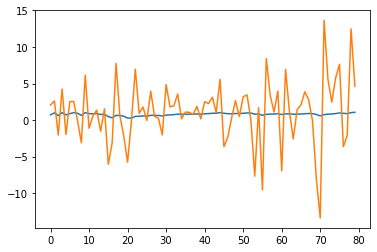

In [6]:
plt.plot(m[-80:])
plt.plot(r[-80:])

In [7]:
MSE = np.square(ε).mean()
print("Out-of-sample MSE = %.3f" %MSE)

Out-of-sample MSE = 19.133


# E


In [8]:
R = data['Mkt-RF'][data.index < pd.to_datetime(201401,format = '%Y%m')][:-1]
R_next = data['Mkt-RF'][data.index < pd.to_datetime(201401,format = '%Y%m')][1:]

In [9]:
import statsmodels.api as sm
import numpy as np

x = sm.add_constant(R.values)
y = R_next.values

model = sm.OLS(y,x)

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     13.68
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           0.000228
Time:                        19:54:22   Log-Likelihood:                -3256.2
No. Observations:                1049   AIC:                             6516.
Df Residuals:                    1047   BIC:                             6526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5747      0.168      3.424      0.0

In [10]:
print("a0 = %.3f, standard error for a0: %.3f" %(res.params[0],res.bse[0]))
print("a1 = %.3f,standard error for a1: %.3f" %(res.params[1],res.bse[1]))

a0 = 0.575, standard error for a0: 0.168
a1 = 0.114,standard error for a1: 0.031


# F

since $ r_{t+1}^e = a_0 + a_1 r_t^e +\epsilon_{t+1}$;

$a_0$ and $a_1$ are known at the start of t+1, and $\epsilon_{t+1} \sim N(0, \sigma_e^2)$

So $r_{t+1}^e \sim N(a_0 + a_1 r_t^e, \sigma_e^2)$

Out-of-sample MSE = 19.254
Bayesian Model is better
<ipython-input-11-4cd38baa2102>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  MSE_F = np.square(ε_F).mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


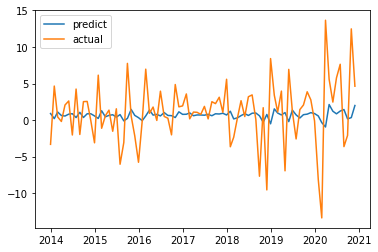

In [11]:
a0 = res.params[0]
a1 = res.params[1]
σe = ((res.resid)**2).mean()**0.5

ε_F = []
r_F = [data['Mkt-RF'][data.index == pd.to_datetime(201312,format = '%Y%m')]]
r_predict=[]
for month in data.index[data.index >= pd.to_datetime(201401,format = '%Y%m')]:
    r_predict.append(a0 + a1*r_F[-1])
    r_realized = data['Mkt-RF'][month]
    ε_F.append(r_realized - r_predict[-1])
    r_F.append(r_realized)

MSE_F = np.square(ε_F).mean()
print("Out-of-sample MSE = %.3f" %MSE_F)
print("Bayesian Model is better")

plt.plot(data.index[data.index >= pd.to_datetime(201401,format = '%Y%m')],r_predict, label = 'predict')
plt.plot(data.index[data.index >= pd.to_datetime(201401,format = '%Y%m')],r_F[1:], label = 'actual')
plt.legend();plt.show()



# G
$R_p = \omega\left(1+r_{t+1}\right)+(1-\omega)(1+r_{f, t})$

$ u = \mathrm{E}_{t}\left[\omega\left(1+r_{t+1}\right)+(1-\omega)\left(1+r_{f, t}\right)\right]-\frac{\alpha}{2} \operatorname{Var}_{t}\left[\omega\left(1+r_{t+1}\right)+(1-\omega)\left(1+r_{f, t}\right)\right]$

FOC: $0 = du/d\omega = \mathrm{E}_t[r_{t+1} - r_{f, t}] -  \alpha \mathrm{E}_t[\omega(R_p - \mathrm{E}_t[R_p])^2] = \mathrm{E}_t[r_{t+1}^e] - \alpha \omega \mathrm{E}_t[(r_{t+1}^e) - \mathrm{E}_t(r_{t+1}^e)] = \mu_{r,t} - \alpha \omega \operatorname{Var}_t[r_{t+1}^e] = \mu_{r,t} - \alpha \omega \sigma_{r,t}^2$

$\Rightarrow \omega_{t}=\frac{\mu_{r, t}}{\alpha \sigma_{r, t}^{2}}$

# F

In [15]:
σ

5.4

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


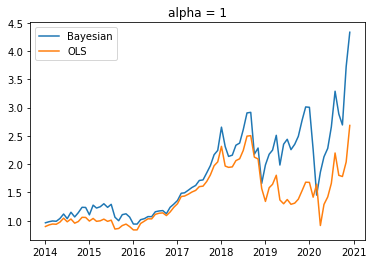

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


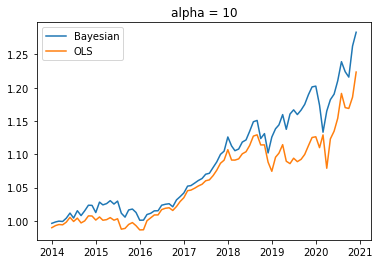

In [17]:
alphas = [1,10] # 10
a0 = res.params[0]
a1 = res.params[1]



for α in alphas:
    # model †
    m = m0
    v = v0
    r = [data['Mkt-RF'][data.index == pd.to_datetime(201312,format = '%Y%m')]]
    portfolio_value_1 = [1];portfolio_value_2 = [1]
    
    T = 0
    months = data.index[data.index >= pd.to_datetime(201401,format = '%Y%m')]

    for month in months:
        T += 1
        ω1 = 100 * m/(α*(v**2+σ**2))
        r_predict = a0 + a1*r[-1]
        ω2 = 100*r_predict/(α*σe**2)
        r.append(data['Mkt-RF'][month])
        portfolio_value_1.append((1 + ω1*r[-1]/100 + data['RF'][month]/100)*portfolio_value_1[-1])         
        portfolio_value_2.append((1 + ω2*r[-1]/100 + data['RF'][month]/100)*portfolio_value_2[-1])

        r_bar = np.mean(r)
        m = (m0*(σ**2) + r_bar*T*(v0**2))/(σ**2+T*v0**2)
        v = np.sqrt((v0*σ)**2/(σ**2 + T*v0**2))

    
    plt.plot(months,portfolio_value_1[1:],label = 'Bayesian')
    plt.plot(months, portfolio_value_2[1:],label = 'OLS')
    plt.legend()

    plt.title('alpha = ' + str(α))
    plt.show()

Bayesian model is better since it procues higher return, and the portfolio value is above OLS method for the most of time during 01/2014 to 12/2020